# Report 1

To run these reports we assume that you have already trained the models and they are saved in their corresponding models. 

This is the report for the first model. It is a scikit-learn logistic regressor. First, lets load some utilities.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pickle
import os
from skimage.transform import rotate, warp, ProjectiveTransform
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

Remember we did some data preprocessing techniques to add variables to the dataset, and here we will show how that work.

First, lets see how many image per class are in the training set:

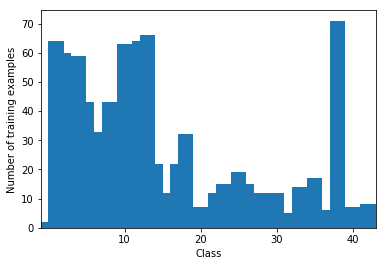

In [2]:
def create_npy_lin(folder):
     """
     This function recieves 'train' or 'test' and creates a npy x file for the
     corresponding directory, for Tensorflow's linear model.
     """
     path = folder
     files = os.listdir(path)
     x = []
     y = []
     all_keypoints = []
     for i, images in sorted(enumerate(files)):
         label = images[0:2] #class identifier is in these positions
         #Sorted because we need the same order as the y files we created earlier.
         image_path = path + '/' + images
         image_read = cv2.imread(image_path, 0) #read in greyscale
         equalized = cv2.equalizeHist(image_read)
         #Need to extract some features, I will extract 10 for every image. Remember
         #that some images are very small so 10 points is okay.
         corners = cv2.goodFeaturesToTrack(equalized, 10, 1e-80, 1)
         #flatten list to correctly pass it to x_train
         flat_list = [item for sublist in corners for item in sublist]
         #Need to this two steps to flatten again correctly because of the way
         #opencv saves points they extract.
         test = np.array(flat_list)
         flatter = [item for subarray in test for item in subarray]
         x.append(flatter)
         y.append(label)
     return x, y

_, y_train = create_npy_lin('../images/train')
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, 2, align='center')
plt.xlabel('Class')
plt.ylabel('Number of training examples')
plt.xlim([-1, 43])
plt.xticks([10, 20, 30, 40], [10, 20, 30, 40])
plt.show()

We can see that the database is quite unbalanced, with some classes with under 5 instances. These way it is very difficult for the algorithms to learn, so we will try to balance the classes adding some images to certain classes using different tricks.

First, we will rotate the images that are are symmetric. That is, the images that when rotated 180 still mantain the same class. One example:

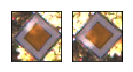

In [3]:
path = '../images/train/12hc.ppm'
img = cv2.imread(path) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cols, rows, _ = img.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
dst = cv2.warpAffine(img, M , (cols,rows))
fig = plt.figure(figsize=(2, 1))
axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
axis.imshow(img)
axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
axis.imshow(dst)
plt.show()

Here you see that the rotated image is more or less the same. Also, we added two types of flipping: the classes that when flipped are in the same class, and the classes that when flipped convert in another class and vice versa. First an example of the first:

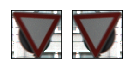

In [4]:
path = '../images/train/13hc.ppm'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
flipped = cv2.flip(img, 1)
fig = plt.figure(figsize=(2, 1))
axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
axis.imshow(img)
axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
axis.imshow(flipped)
plt.show()

Again, the classes are similar when flipped, so we can create easy duplicates to inflate our database. Now for classes that turn into each other when flipped, lets check classes Dangerous turn to the left and dangerous turn to the right:

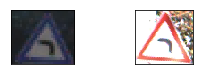

In [5]:
left = '../images/train/19hc.ppm'
right = '../images/train/20hc.ppm'
imgl = cv2.imread(left)
imgr = cv2.imread(right)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)
flipped_l = cv2.flip(imgl, 1)
flipped_r = cv2.flip(imgr, 1)
fig = plt.figure(figsize=(4, 1))
axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
axis.imshow(imgl)
axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
axis.imshow(flipped_r)
plt.show()

You can see there the original left and the flipped left.

That's it for data preprocessing. Not let's see how our model fares up. Lets load it and run it:

In [6]:
x_test, y_test = create_npy_lin('../images/test')
with open('../models/model1/saved/model1.p', 'rb') as handle:
    lr = pickle.load(handle)
    good = 0.0
    total = len(y_test)

    predictions = lr.predict(x_test)
    for i, instance in enumerate(x_test):
        if predictions[i] == y_test[i]:
             good += 1

    accuracy = good/total
    print('good: ' + str(good))
    print('total: ' + str(total))
    print('acc: ' + str(accuracy))

good: 25.0
total: 269
acc: 0.092936802974


As you see it is not a very good score. That may be because a linear model does not fare very well in image classification, not even with feature extractions. Thinking about a linear function that could separate images is very strange, as the relationship between images (and their features) is highly nonlinear.